# Introduction

Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

In this tutorial was used a variant of BERT called [DistilBERT](https://arxiv.org/abs/1910.01108) V. Sanh et al., "DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter", (2019).

Notice that I'm following the book: *[Natural language processing with transformers](https://books.google.pt/books?hl=en&lr=&id=nzxbEAAAQBAJ&oi=fnd&pg=PP1&dq=natural+language+processing+with+hugging+face+book&ots=sUngJ_q1JE&sig=jA559R-MigxWmh5vZQtpTJSeJkU&redir_esc=y#v=onepage&q=natural%20language%20processing%20with%20hugging%20face%20book&f=false)*.

# Instalations

In [ ]:
! pip install 'transformers[torch]'

In [ ]:
! pip install datasets

In [ ]:
! pip install scikit-learn

In [ ]:
! pip install huggingface_hub

In [ ]:
! pip install pandas

In [ ]:
! pip install matplotlib

In [ ]:
! pip install torch

In [ ]:
! pip install umap-learn

# Dataset

Load datasets from Hugging Face hub

In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")

There are 86976 datasets currently available on the Hub


#### or

In [2]:
import huggingface_hub

all_datasets_generator = huggingface_hub.list_datasets()
all_datasets_list = list(all_datasets_generator)

print(f"There are {len(all_datasets_list)} datasets currently available on the Hub")

There are 86975 datasets currently available on the Hub


In [4]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


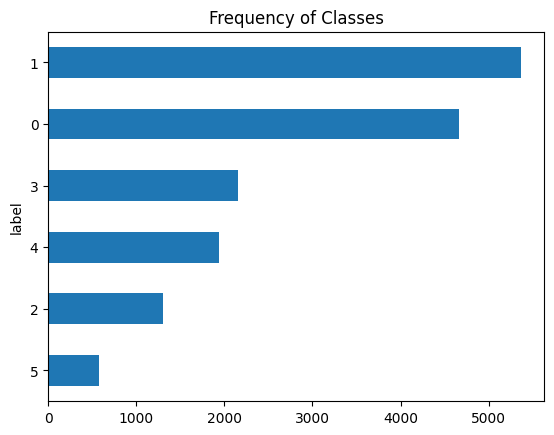

In [7]:
import matplotlib.pyplot as plt

df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [8]:
emotions.reset_format()

# Tokens

In [9]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [10]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map: 100%|██████████| 2000/2000 [00:00<00:00, 32936.93 examples/s]


# Training a Text Classifier

## Transformers as Feature Extractors

In [12]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [13]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

print(emotions_hidden)

Map: 100%|██████████| 2000/2000 [00:18<00:00, 110.52 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})


In [14]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [15]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,X,Y,label
0,4.049836,5.788452,0
1,-3.352516,4.615790,0
2,5.218822,2.447431,3
3,-2.549302,2.720237,2
4,-3.500310,2.675371,3


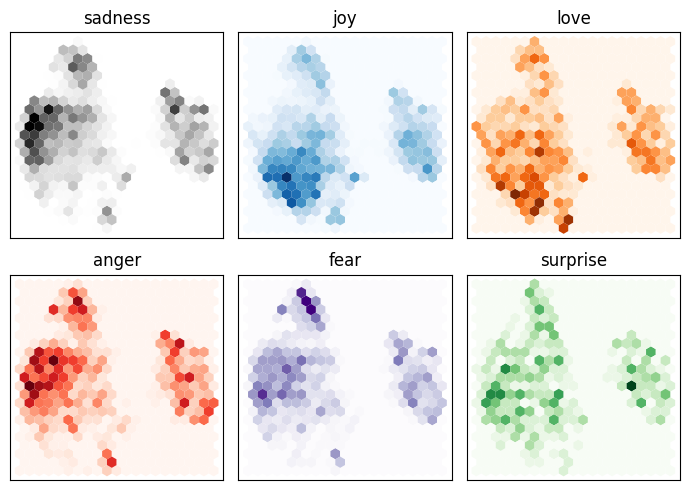

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [18]:
lr_clf.score(X_valid, y_valid)

0.633

In [19]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

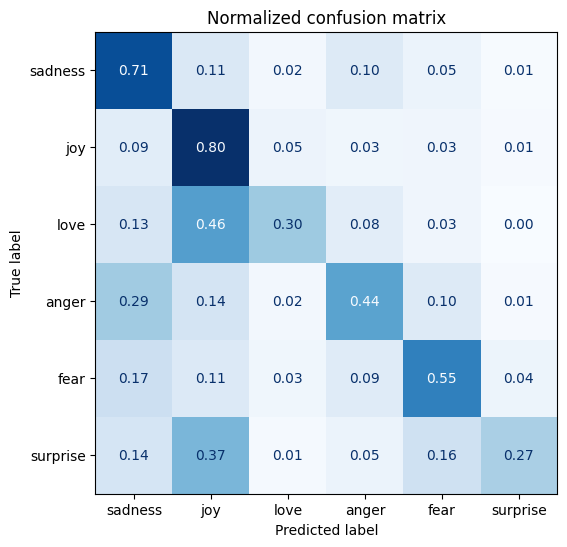

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# Reference

1. Tunstall, Lewis and Von Werra, Leandro and Wolf, Thomas. (2022). *[Natural language processing with transformers](https://books.google.pt/books?hl=en&lr=&id=nzxbEAAAQBAJ&oi=fnd&pg=PP1&dq=natural+language+processing+with+hugging+face+book&ots=sUngJ_q1JE&sig=jA559R-MigxWmh5vZQtpTJSeJkU&redir_esc=y#v=onepage&q=natural%20language%20processing%20with%20hugging%20face%20book&f=false)*. O'Reilly Media, Inc.

## Additional Resources

- [Hugging Face Official Documentation](https://huggingface.co/docs)
- [Hugging Face Model Hub](https://huggingface.co/models)